## Многомерная линейная регрессия

До этого мы рассматривали только один признак - среднее число комнат на участке. Давайте в нашу модель добавим еще один признак - процент жителей с низким социальным статусом (`LSTAT`).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from math import sqrt

In [2]:
boston = load_boston()

In [96]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target

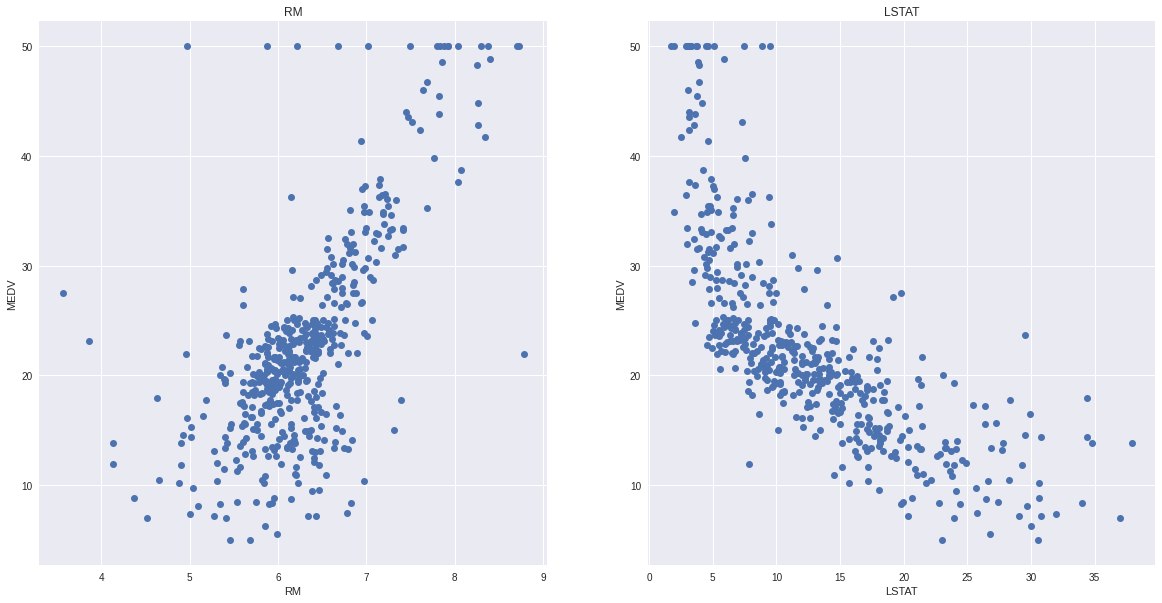

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
for i, col in enumerate(["RM", "LSTAT"]):
    plt.subplot(1, 2, (i+1))
    plt.plot(data[col], data["MEDV"], 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [97]:
data = data.loc[(data['MEDV'] != 50) & (data['RM'] != 8.78) & (data['RM'] > 4)]
X_filtered = data[["RM", "LSTAT"]]
X_filtered.is_copy = False
y_filtered = data["MEDV"]
X_filtered.is_copy = False

In [7]:
def z_scaler(X):
    if len(X.shape) == 1:
        mean = sum(X) / len(X)
        std = sqrt(sum([(x - mean) ** 2 for x in X]) / (len(X) - 1))
        X = [(x - mean) / std for x in X]
        return X
    for col in X.columns:
        mean = sum(X[col]) / len(X[col])
        std = sqrt(sum([(x - mean) ** 2 for x in X[col]]) / (len(X[col]) - 1))
        X[col] = [(x - mean) / std for x in X[col]]
        return X

In [162]:
class GDRegressor:
    
    def __init__(self, alpha=0.01, n_iter=100):
        self.alpha = alpha
        self.n_iter = n_iter

    def fit(self, X, y):
        X = np.hstack([np.ones((len(X), 1)), X]) 
        theta = np.zeros(X.shape[1]) 
        self.theta_history = theta.copy()
        m = len(X)   
        cost_history = []
        for i in range(self.n_iter):
            predictions = X.dot(theta)  
            cost = 0
            error = X.dot(theta) - y 
            gradient = (1 / m) * (X.T.dot(error))
            theta -= self.alpha * gradient
            self.theta_history = np.vstack([self.theta_history, theta])
            cost = np.sum((predictions - y)**2) / (2 * m)
            cost_history.append(cost)            
        self.loss_history = cost_history[::-1]
        self.theta = theta
        self.intercept_ = theta[0]
        self.coef_ = theta[1:]

    def predict(self, X_test):
        return np.hstack([np.ones((len(X_test), 1)), X_test]).dot(self.theta)

In [98]:
pd.options.mode.chained_assignment = None
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [163]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=300)
%time model.fit(X_train, Y_train)

CPU times: user 23.2 ms, sys: 3.96 ms, total: 27.2 ms
Wall time: 25.3 ms


In [164]:
def plot_loss_function(model):
    plt.xlabel("Iterations")
    plt.ylabel("Average square loss")
    plt.plot(np.arange(model.n_iter), model.loss_history);

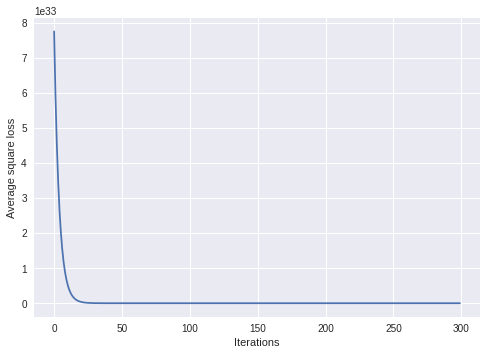

In [165]:
plot_loss_function(model)

In [11]:
def rmse(y_hat, y):
    sum1 = 0
    for i in range(len(list(y_hat))):
        sum1 += (list(y)[i] - list(y_hat)[i])**2
    result = (sum1 / len(y))**0.5
    return result

In [43]:
def r_squared(y_hat, y):
    y_mean = np.mean(y)
    sum1 = sum2 = 0
    for i in range(len(list(y))):
        sum1 += (list(y)[i] - list(y_hat)[i])**2
        sum2 += (list(y)[i] - y_mean)**2
    result = 1 - (sum1 / sum2)
    return result

In [13]:
Y_pred = model.predict(X_test)
rmse(Y_pred, Y_test), r_squared(Y_pred, Y_test)

(1.4681333478759773e+17, -1.6630921304785533e+34)

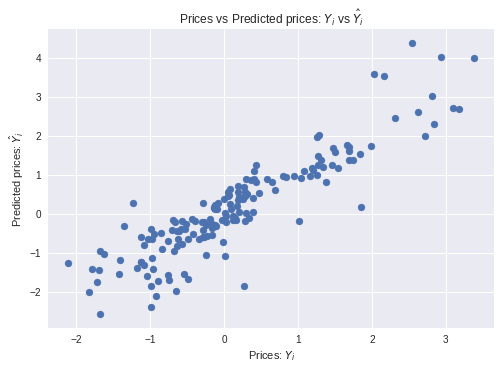

In [234]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

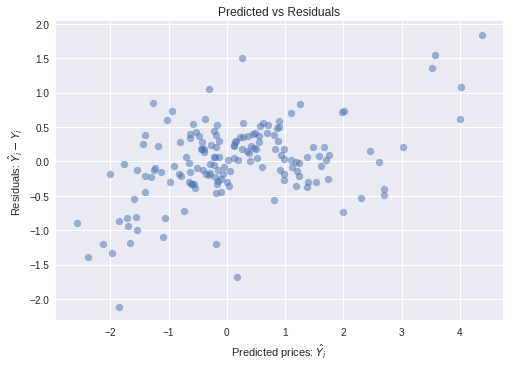

In [235]:
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
plt.scatter(Y_pred, (Y_pred - np.ravel(Y_test)), alpha=0.5);

Из графика хорошо видно, что есть нелинейная зависимость в остатках. Это связано с тем, что процент жителей с низким социальным статусом нелинейно зависит от средней цены на дом и среднего числа комнат:

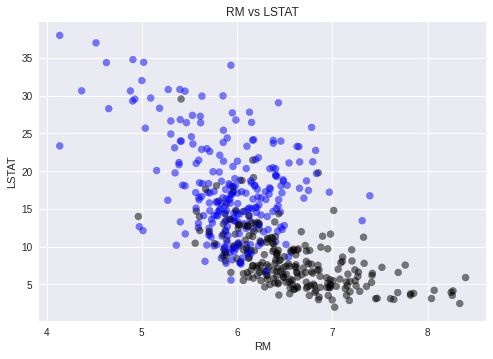

In [74]:
colors = ['k' if v > data["MEDV"].median() else 'b' for v in data["MEDV"]]
plt.scatter(data["RM"], data["LSTAT"], c=colors, alpha=0.5)
plt.xlabel("RM");
plt.ylabel("LSTAT");
plt.title("RM vs LSTAT")
plt.show()

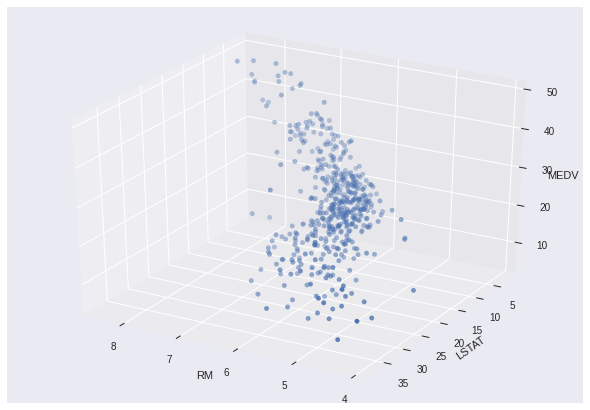

In [75]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()#figsize=(15, 10))
ax = Axes3D(fig)
ax.set_xlabel('RM')
ax.set_ylabel('LSTAT')
ax.set_zlabel('MEDV');
ax.view_init(azim=120)
ax.scatter3D(data["RM"], data["LSTAT"], data["MEDV"])
plt.show()

Эту зависимость наша модель в настоящий момент не описывает. Таким образом, мы должны добавить в нашу модель нелинейные признаки.

### Добавление полиномиальных признаков

Итак, для описания нелинейной зависимости мы будем использовать полиномиальную модель. Предположим, что полинома четвертой степени достаточно для описания зависимости. Возможно будет достаточно полинома второй или третьей степени, поэтому, чтобы «занулить» некоторые коэффициенты $\theta$, мы будем использовать L1-регуляризацию.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

In [15]:
poly = PolynomialFeatures(4, include_bias=False)
X_filtered_poly = poly.fit_transform(X_filtered)

In [16]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, y_filtered, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [17]:
model = SGDRegressor(
    loss='squared_loss',
    penalty='l1',
    alpha=0.01,
    learning_rate='constant',
    max_iter=1000,
    eta0=0.005
)
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [18]:
Y_pred = model.predict(X_test)

In [19]:
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.28650110794961925, 0.8160954466956383)

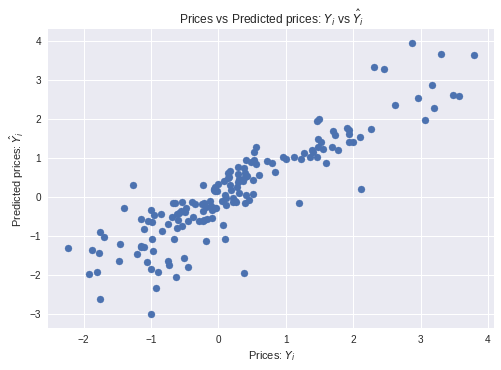

In [61]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

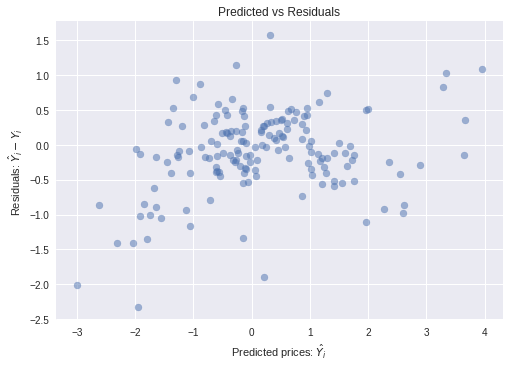

In [62]:
fig = plt.figure()
plt.scatter(Y_pred, (Y_pred-Y_test.reshape(1, -1)), alpha=0.5);
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
fig.savefig('lr_residuals3.png', dpi=fig.dpi)

In [20]:
model.coef_, model.intercept_

(array([ 0.35825004, -0.47320186,  0.22189145, -0.0387652 , -0.20482866,
         0.08146196,  0.        , -0.14134648,  0.        , -0.06517206,
         0.        ,  0.        , -0.10383775,  0.        ]),
 array([0.00587445]))

In [21]:
poly.get_feature_names(X_filtered.columns)

['RM',
 'LSTAT',
 'RM^2',
 'RM LSTAT',
 'LSTAT^2',
 'RM^3',
 'RM^2 LSTAT',
 'RM LSTAT^2',
 'LSTAT^3',
 'RM^4',
 'RM^3 LSTAT',
 'RM^2 LSTAT^2',
 'RM LSTAT^3',
 'LSTAT^4']

### Кривые обучения

In [65]:
def learning_curves(estimator, data, features, target, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =
    train_sizes,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title(str(features), fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,70)

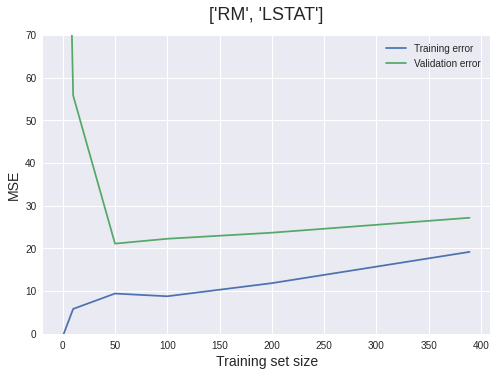

In [66]:
train_sizes = [1, 10, 50, 100, 200, 389]
target = 'MEDV'
features = ['RM', 'LSTAT']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

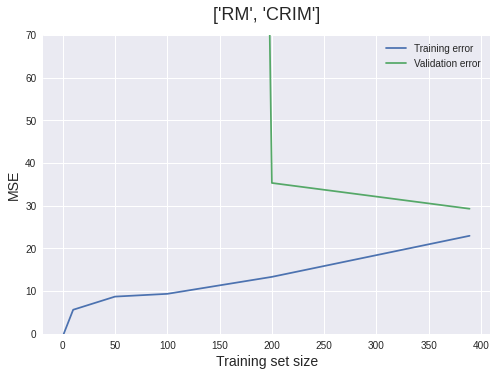

In [67]:
features = ['RM', 'CRIM']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

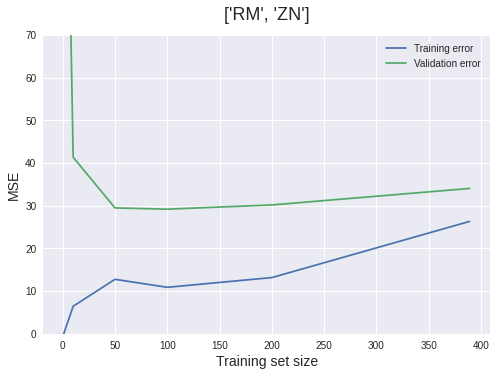

In [68]:
features = ['RM', 'ZN']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

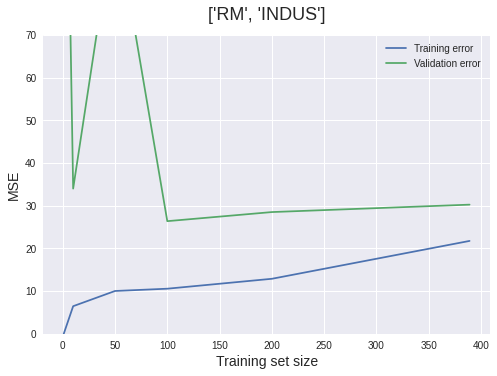

In [69]:
features = ['RM', 'INDUS']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

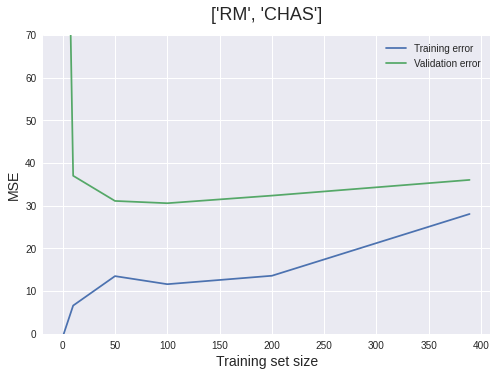

In [70]:
features = ['RM', 'CHAS']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

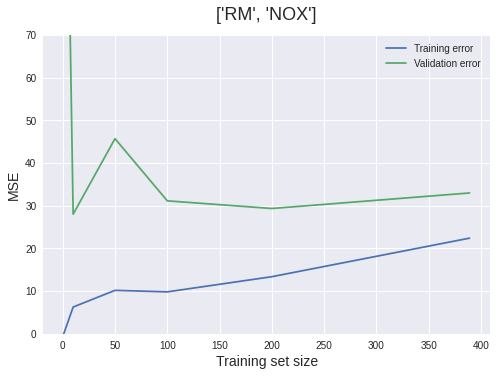

In [71]:
features = ['RM', 'NOX']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

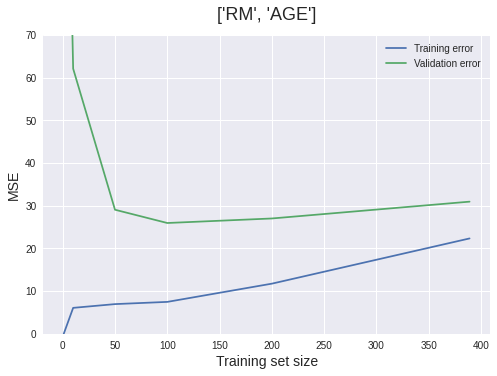

In [72]:
features = ['RM', 'AGE']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

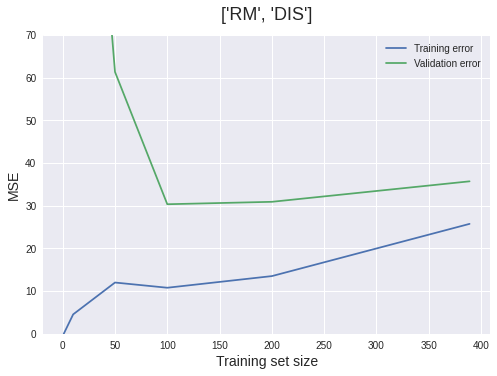

In [73]:
features = ['RM', 'DIS']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

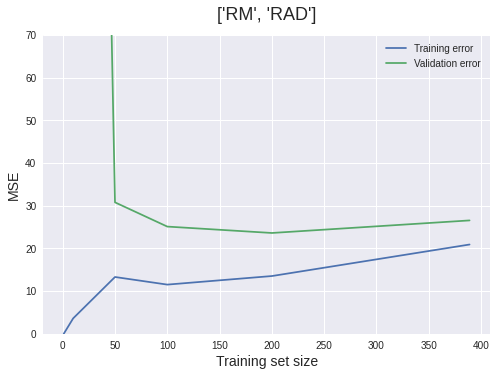

In [74]:
features = ['RM', 'RAD']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

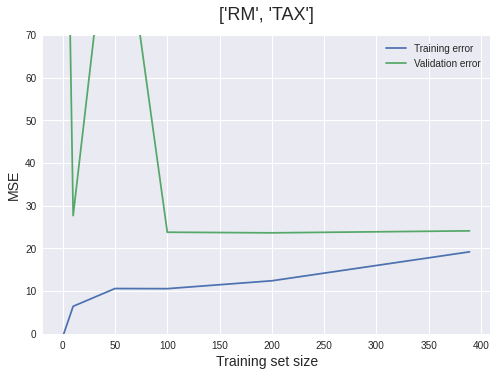

In [75]:
features = ['RM', 'TAX']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

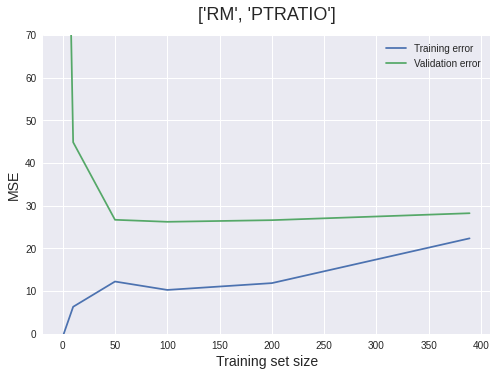

In [76]:
features = ['RM', 'PTRATIO']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

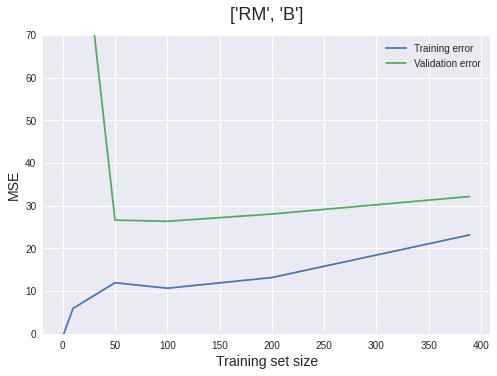

In [77]:
features = ['RM', 'B']
learning_curves(LinearRegression(), data, features, target, train_sizes, cv=5)

In [22]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT", "ZN", "PTRATIO"]]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [23]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [24]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=100)
%time model.fit(X_train, Y_train)

CPU times: user 17 ms, sys: 588 µs, total: 17.6 ms
Wall time: 16.4 ms


### L2 Regularization (Ridge) 

In [185]:
class RidgeRegression:
    
    def __init__(self, n_iter=100, l = 0.1, intercept=False):
        self.n_iter = n_iter
        self.l = l
        self.intercept = intercept

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.full((n,), 0.33)
        for i in range(self.n_iter):
            theta_old = tuple(self.theta)
            for j in range(n):
                x_j = np.array([X[i][j] for i in range(len(X))])
                y_hypoth = X.dot(self.theta)
                rho = x_j.T.dot(pd.Series(y - y_hypoth + self.theta[j] * x_j))
                z_j = sum(x_j ** 2)
                if self.intercept and j == 0:
                    self.theta[j] = rho / z_j
                    continue
                elif j == 0:
                    self.theta[j] = (rho - self.l)**2 / z_j

    def predict(self, X_test):
        return X_test.dot(self.theta)

In [186]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered_poly, y_filtered, test_size=0.33, random_state=18)
model = RidgeRegression(n_iter=100, l=0.1, intercept=True)
%time model.fit(X_train, Y_train)

CPU times: user 725 ms, sys: 0 ns, total: 725 ms
Wall time: 724 ms


### Задания

- Постройте кривые обучения
- Какие еще признаки, кроме `LSTAT`, могут улучшить нашу модель? Отберите лучшие, ориентируйтесь на кривые обучения, а также проверяйте ваши модели на валидационных данных.
- Добавьте L2 (Lasso) регуляризацию в класс `GDRegressor`